In [34]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from utils.visualization_utils import get_dict

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
###################
data_type = "clevr"
###################
if data_type=="vrd":
    nrows = 7
    ncols=10
    fontsize = 12
    figsize = (14,20)
    max_images = None
    annotations_file = "data/VRD/annotations_train.json"
    vocab_dir = os.path.join('data/VRD')
elif data_type=="clevr":
    nrows = 1
    ncols = 4
    fontsize = 22
    figsize = (20,10)
    max_images = 1000
    annotations_file = "/data/ranjaykrishna/ReferringRelationships/data/clevr/annotations_train.json"
    vocab_dir = os.path.join('/data/ranjaykrishna/ReferringRelationships/data/clevr')
elif data_type=="visualgenome":
    nrows=7
    ncols=10
    fontsize = 12
    figsize = (14,20)
    max_images = None
    annotations_file = "/data/ranjaykrishna/ReferringRelationships/data/VisualGenome/VisualGenome/annotations_train.json"
    vocab_dir = os.path.join('/data/ranjaykrishna/ReferringRelationships/data/VisualGenome/VisualGenome/')

In [84]:
predicate_dict, obj_subj_dict = get_dict(vocab_dir)
annotations = json.load(open(annotations_file))
print(' | '.join(predicate_dict))

left | right | front | behind


In [85]:
def get_vec(s_bbox, o_bbox):
    s_center = ((s_bbox[0]+s_bbox[1])/2., (s_bbox[2]+s_bbox[3])/2.)
    o_center = ((o_bbox[0]+o_bbox[1])/2., (o_bbox[2]+o_bbox[3])/2.)
    vec = np.array([o_center[0]-s_center[0], o_center[1]-s_center[1]])
    return s_center, vec
def get_score(i, j, f_center, vec, eps=10e-8):
    current_vec = np.array([i-f_center, j-f_center])
    score = vec.dot(current_vec)/((10e-8 + max(np.linalg.norm(current_vec), np.linalg.norm(vec)))**2)
    return score
def get_filter(vec, s_center, filter_size=10):
    f_center = filter_size / 2
    filter_template = np.zeros((1, filter_size, filter_size))
    for i in range(filter_size):
        for j in range(filter_size):
            filter_template[0, i, j] = get_score(i, j, f_center, vec)
    return filter_template

In [86]:
shifts = {}
inv_shifts = {}
shift_list = {}
inv_shift_list = {}
progress = 0
for img in annotations:
    for rel in annotations[img]:
        s_bbox = rel["subject"]["bbox"]
        o_bbox = rel["object"]["bbox"]
        s_center, vec = get_vec(s_bbox, o_bbox)
        o_center, inv_vec = get_vec(o_bbox, s_bbox)
        predicate = predicate_dict[rel["predicate"]]
        if predicate not in shift_list:
            shift_list[predicate] = []
            inv_shift_list[predicate] = []
        shift_list[predicate].append(get_filter(vec, s_center))
        inv_shift_list[predicate].append(get_filter(inv_vec, o_center))
    if progress % 100 == 0:
        print('Progress: ', progress)
    progress += 1
    if max_images is not None and progress >= max_images:
        break
for predicate in shift_list:
    filters = np.concatenate(shift_list[predicate], axis=0).mean(axis=0)
    inv_filters = np.concatenate(inv_shift_list[predicate], axis=0).mean(axis=0)
    shifts[predicate] = filters
    inv_shifts[predicate] = inv_filters

Progress:  0
Progress:  100
Progress:  200
Progress:  300
Progress:  400
Progress:  500
Progress:  600
Progress:  700
Progress:  800
Progress:  900


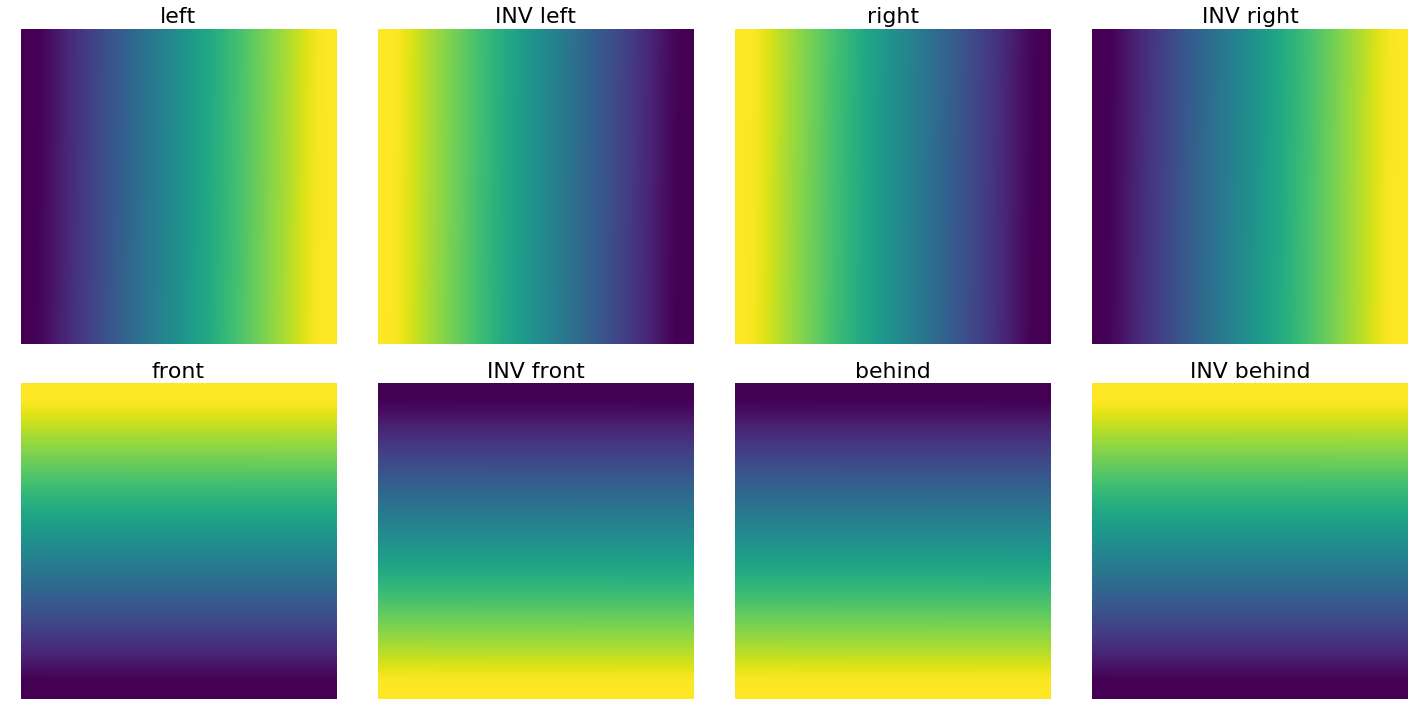

In [88]:
interp_method = 'spline16'
fig, axs = plt.subplots(nrows=nrows*2, ncols=ncols, figsize=figsize)
fig.tight_layout()
row = 0
col = 0
for predicate in predicate_dict:
    try:
        ax = axs[row, col]
        im = shifts[predicate]
        plot = ax.imshow(im, interpolation=interp_method)
        ax.set_title(predicate, {"fontsize":fontsize})
        ax.axis("off")
        ax = axs[row, col+1]
        im = inv_shifts[predicate]
        plot = ax.imshow(im, interpolation=interp_method)
        ax.set_title("INV {}".format(predicate), {"fontsize":fontsize})
        ax.axis("off")
    except:
        pass
    col += 2
    if col >= ncols:
        row += 1
        col = 0
for row in range(nrows*2):
    for col in range(ncols):
        ax = axs[row, col]
        ax.axis("off")